In [1]:
import numpy as np
import matplotlib 
import matplotlib as mpl
from astropy.stats import LombScargle
from astropy.stats import sigma_clip
from scipy.signal import savgol_filter
from astropy.io import fits

import halophot
from halophot.halo_tools import halo_tpf
import lightkurve 
from lightkurve import TessTargetPixelFile, TessLightCurveFile, TessLightCurve

print(halophot.__version__)

0.6.3.5


In [2]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=22              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

Populating the interactive namespace from numpy and matplotlib


In [4]:
from astroquery.mast import Observations
obsTable = Observations.query_object("nu Ind")

In [5]:
obsTable

dataproduct_type,obs_collection,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,proposal_id,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,distance
str10,str5,str13,str12,str9,str10,str22,str32,str88,float64,float64,str23,str26,int64,float64,float64,float64,float64,float64,str108,float64,str12,int64,str1775,str138,str137,str6,bool,float64,str11,str11,float64
image,TESS,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0001-3-2,342.44659866342755,-71.66901526939581,N/A,"Ricker, George",3,58324.81528598,58352.66913409,1425.599483,600.0,1000.0,--,58458.58334,--,1,POLYGON 18.223111 -72.104555 18.217786963357895 -72.103797364706338 18.218026 -72.103623 8.53413322005509 -70.340427880448246 -7.5883610000000772 -64.869338 -7.5890061988292263 -64.869583154307648 -7.589439000000084 -64.869372 -7.5895509673494983 -64.869414543139285 -7.5900420000000395 -64.869175 -7.5903071086177754 -64.86927574921198 -7.5905299999999443 -64.869167 -7.5906198912396521 -64.869201153843349 -7.5906529999999748 -64.869185 -7.5906979701591881 -64.8692020862304 -7.5911060000000816 -64.869003 -7.5911473474886888 -64.869018709484564 -7.5911570000000665 -64.869014 -7.591186164302016 -64.869025080883475 -7.5913379999999506 -64.868951 -15.05742391441442 -67.273079088444646 -36.005718 -70.835479 -36.005617850680835 -70.83561695260228 -36.00588399999998 -70.835641 -36.00583419124024 -70.8357096033502 -36.006392000000005 -70.83576 -36.006391433388195 -70.835760780515614 -36.006416 -70.835763 -36.006415503384432 -70.835763684096335 -36.006418999999994 -70.835764 -36.006418002544471 -70.835765374012453 -36.006436000000008 -70.835767 -36.006434637475742 -70.8357688769022 -36.006436000000008 -70.835769 -36.006430796100879 -70.835776168470233 -36.00644 -70.835777 -36.00643461145318 -70.835784422824446 -36.006440999999995 -70.835785 -36.006436354265638 -70.835791399589709 -36.00644299999999 -70.835792 -36.005389200961112 -70.837243520594029 -36.007684999999981 -70.837451 -17.227428529431513 -81.681506202409892 -16.630266000000006 -81.818475 -16.62771791129331 -81.818239202452759 -16.627283000000034 -81.818337 -16.626737827213532 -81.818286546317026 -16.625068000000056 -81.818662 -16.621822549461641 -81.818361612008161 -16.621376000000055 -81.818462 18.223073 -72.104677 18.222964834790691 -72.104661609651018 18.223111 -72.104555 18.223111 -72.104555,--,--,PUBLIC,False,--,17000035426,17000600390,0.0
timeseries,TESS,Photometer,TESS,TESS,Optical,317019578,--,tess2018206045859-s0001-0000000317019578-0120-s,336.153731,-72.255392,G011155_G011025_G011048,"Ricker, George",3,58324.79285543,58352.6761776,120.0,600.0,1000.0,--,58458.58334,--,1,CIRCLE ICRS 336.15373100 -72.25539200 0.00138889,--,mast:TESS/product/tess2018206045859-s0001-0000000317019578-0120-s_lc.fits,PUBLIC,False,--,17000011122,17000089009,0.0
timeseries,TESS,Photometer,TESS,TESS,Optical,316992294,--,tess2018206045859-s0001-0000000316992294-0120-s,335.6814,-72.2623,G011180,"Ricker, George",3,58324.79285543,58352.6761776,120.0,600.0,1000.0,--,58458.58334,--,1,CIRCLE ICRS 335.68140000 -72.26230000 0.00138889,--,mast:TESS/product/tess2018206045859-s0001-0000000316992294-0120-s_lc.fits,PUBLIC,False,--,17000000424,17000055301,513.6834113980493
timeseries,TESS,Photometer,TESS,TESS,Optical,317020182,--,tess2018206045859-s0001-0000000317020182-0120-s,336.530405,-72.413223,N/A,"Ricker, George",3,58324.79285543,58352.6761776,120.0,600.0,1000.0,--,58458.58334,--,1,CIRCLE ICRS 336.53040500 -72.41322300 0.00138889,--,mast:TESS/product/tess2018206045859-s0001-0000000317020182-0120-s_lc.fits,PUBLIC,False,--,17000005001,17000072983,696.5480701034617
spectrum,IUE,LWP,--,LOW DISP,UV,HD 211998,--,lwp03551,336.0942845476,-72.246174171,CSGEB,Bohm-Vitense,2,45862.36076,45862.36122,39.608,185118000000.0,334760000000.0,G and Early K Giant UV Continua and Early Emiss

In [8]:
obsTable[1]

dataproduct_type,obs_collection,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,proposal_id,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,distance
str10,str5,str13,str12,str9,str10,str22,str32,str88,float64,float64,str23,str26,int64,float64,float64,float64,float64,float64,str108,float64,str12,int64,str1775,str138,str137,str6,bool,float64,str11,str11,float64
timeseries,TESS,Photometer,TESS,TESS,Optical,317019578,--,tess2018206045859-s0001-0000000317019578-0120-s,336.153731,-72.255392,G011155_G011025_G011048,"Ricker, George",3,58324.79285543,58352.6761776,120.0,600.0,1000.0,--,58458.58334,--,1,CIRCLE ICRS 336.15373100 -72.25539200 0.00138889,--,mast:TESS/product/tess2018206045859-s0001-0000000317019578-0120-s_lc.fits,PUBLIC,False,--,17000011122,17000089009,0.0


In [9]:
dataProductsByObservation = Observations.get_product_list(obsTable[1])

In [ ]:
Observations.download_products('17000011122',
                                   productType="SCIENCE")

In [ ]:
fname1 = '../data/nuInd/tess2018206045859-s0001-0000000317019578-0120-s_tp.fits'

In [ ]:
tpf1 = lightkurve.open(fname1)
# maxflux1 = np.nanmax(tpf1.flux)<
# print(maxflux1)

dummy1 = tpf1.flux.copy()
m1 = (tpf1.quality == 0) # get bad quality 
dummy1[m1,:,:][dummy1[m1,:,:]<0] = 0

In [5]:
thresh = 55000
saturated = np.nanmax(dummy1[m1,:,:],axis=0) > thresh #*maxflux1)
print('%d saturated pixels' % np.sum(saturated))

21 saturated pixels


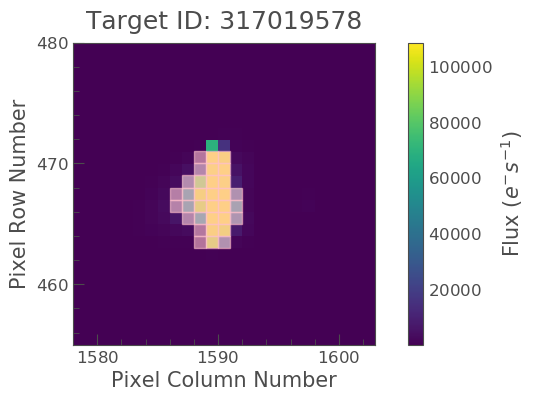

In [6]:
tpf1.plot(frame=1,aperture_mask=tpf1.pipeline_mask)

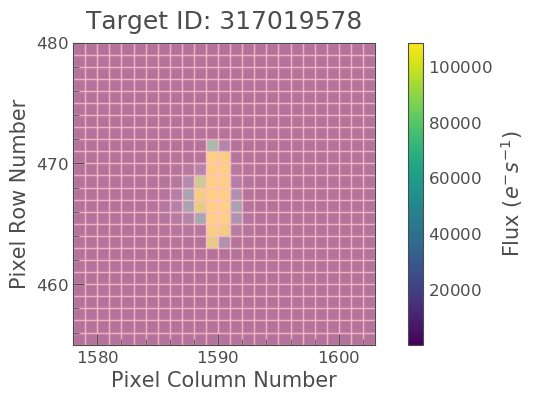

In [7]:
newmask = np.ones((tpf1.flux.shape[1],tpf1.flux.shape[2]),dtype='bool')
xx, yy = np.meshgrid(np.arange(newmask.shape[0]),np.arange(newmask.shape[1]))

ymin = 5
ymax = 21

xmin = 6
xmax = 18
# newmask = np.ones((tpf.flux.shape[1],tpf.flux.shape[2]),dtype='bool')
# xx, yy = np.meshgrid(np.arange(newmask.shape[0]),np.arange(newmask.shape[1]))

# newmask[(xx<ymin).T] = False
# newmask[(xx>ymax).T] = False
# newmask[(yy<xmin).T] = False
# newmask[(yy>xmax).T] = False

tpf1.plot(frame=1,aperture_mask=newmask)

In [8]:
tpf1 = halo_tpf(fname1)

In [9]:
%%time
weightmap11, corr_lc11 = tpf1.halo(order=2,mask=newmask,minflux=-100,thresh=-1,splits=(None,9221))
weightmap12, corr_lc12 = tpf1.halo(order=2,mask=newmask,minflux=-100,thresh=-1,splits=(9222,14687))
weightmap13, corr_lc13 = tpf1.halo(order=2,mask=newmask,minflux=-100,thresh=-1,splits=(14688,15340))
weightmap14, corr_lc14 = tpf1.halo(order=2,mask=newmask,minflux=-100,thresh=-1,splits=(15341,None));

Taking cadences from beginning to 9221
Searching for number of saturated pixels to cut between 0 and 20
Taking cadences from beginning to end
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from beginning to end
1 saturated pixels
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from beginning to end
2 saturated pixels
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from beginning to end
3 saturated pixels
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from beginning to end
4 saturated pixels
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from beginning to end
5 saturated pixels
Censored TPF
Subsampling by 

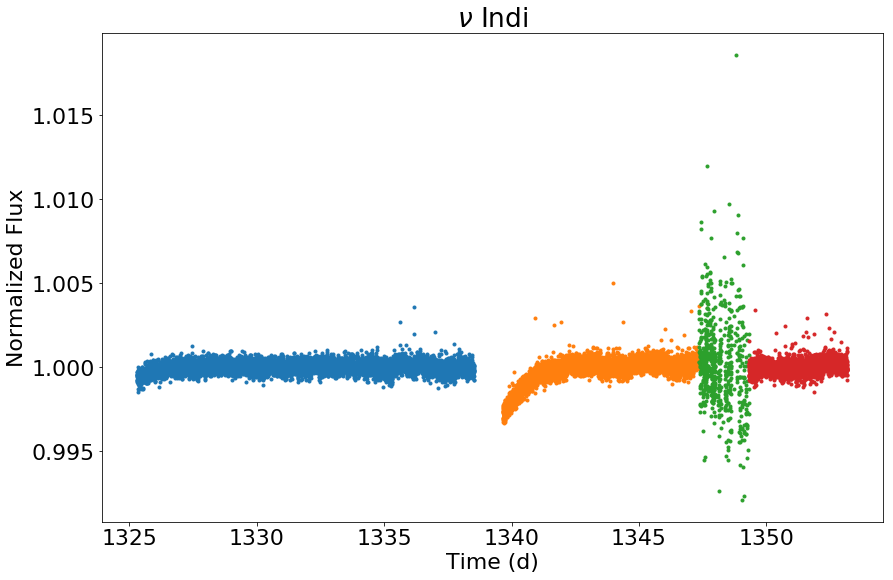

In [10]:
fig = plt.figure(figsize=(14,9))
plt.plot(corr_lc11.time,corr_lc11.flux/np.nanmedian(corr_lc11.flux),'.')
plt.plot(corr_lc12.time,corr_lc12.flux/np.nanmedian(corr_lc12.flux),'.')
plt.plot(corr_lc13.time,corr_lc13.flux/np.nanmedian(corr_lc13.flux),'.')
plt.plot(corr_lc14.time,corr_lc14.flux/np.nanmedian(corr_lc14.flux),'.')

# plt.plot(lc.time, lc.flux/np.nanmedian(lc.flux),'.',label='Sum')
# plt.xlim(1345,1350)
# plt.ylim(1.004,1.01)
plt.ylabel('Normalized Flux')
plt.xlabel('Time (d)')
plt.title('$\\nu$ Indi')
plt.savefig('nu-Ind-test.png')

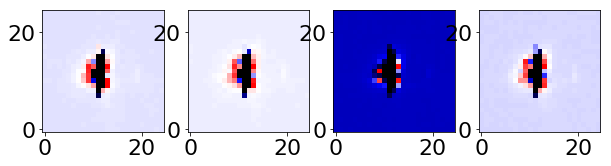

In [11]:
fig,axes = plt.subplots(1,4)

cmap = mpl.cm.seismic
norm = np.size(weightmap11)
cmap.set_bad('k',1.)
im = np.log10(weightmap11.T*norm)
axes[0].imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
    interpolation='None',origin='lower')
im = np.log10(weightmap12.T*norm)
axes[1].imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
    interpolation='None',origin='lower')
im = np.log10(weightmap13.T*norm)
axes[2].imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
    interpolation='None',origin='lower')
im = np.log10(weightmap14.T*norm)
axes[3].imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
    interpolation='None',origin='lower')

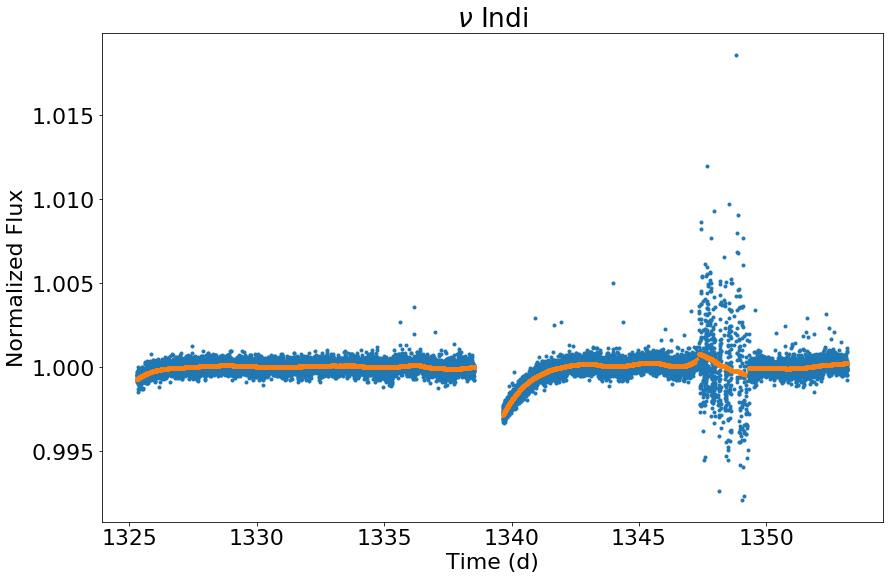

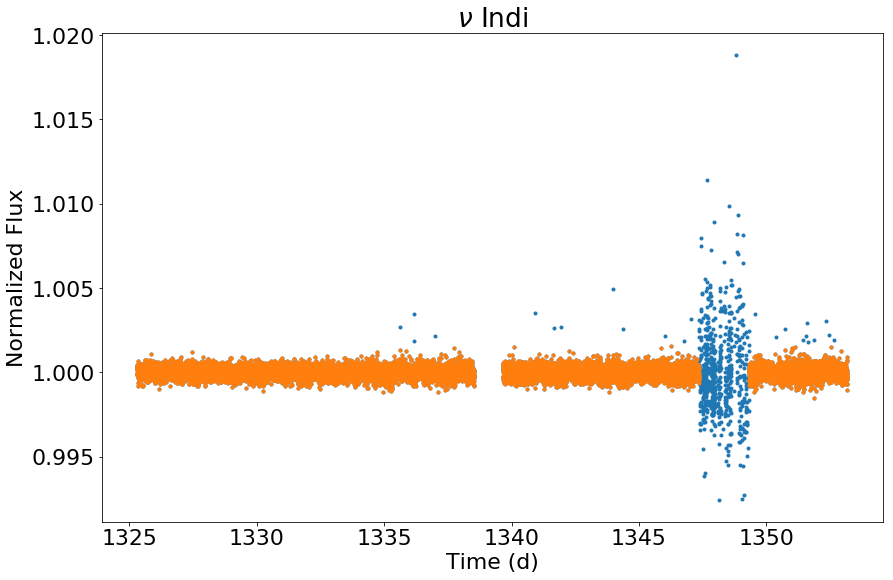

In [12]:
ts11 = corr_lc11.time[~numpy.isnan(corr_lc11.flux)]
fs11 = corr_lc11.flux[~numpy.isnan(corr_lc11.flux)]/np.nanmedian(corr_lc11.flux)
ts12 = corr_lc12.time[~numpy.isnan(corr_lc12.flux)]
fs12 = corr_lc12.flux[~numpy.isnan(corr_lc12.flux)]/np.nanmedian(corr_lc12.flux)
ts13 = corr_lc13.time[~numpy.isnan(corr_lc13.flux)]
fs13 = corr_lc13.flux[~numpy.isnan(corr_lc13.flux)]/np.nanmedian(corr_lc13.flux)
ts14 = corr_lc14.time[~numpy.isnan(corr_lc14.flux)]
fs14 = corr_lc14.flux[~numpy.isnan(corr_lc14.flux)]/np.nanmedian(corr_lc14.flux)

sfs11 = savgol_filter(fs11,2001,3)
sfs12 = savgol_filter(fs12,2001,3)
sfs13 = savgol_filter(fs13,601,1)
sfs14 = savgol_filter(fs14,1001,1)

fig = plt.figure(figsize=(14,9))
plt.plot(ts11,fs11,'C0.')
plt.plot(ts11,sfs11,'C1.')

plt.plot(ts12,fs12,'C0.')
plt.plot(ts12,sfs12,'C1.')

plt.plot(ts13,fs13,'C0.')
plt.plot(ts13,sfs13,'C1.')

plt.plot(ts14,fs14,'C0.')
plt.plot(ts14,sfs14,'C1.')

plt.ylabel('Normalized Flux')
plt.xlabel('Time (d)')
plt.title('$\\nu$ Indi')

fig = plt.figure(figsize=(14,9))

plt.plot(ts11,fs11/sfs11,'C0.')
plt.plot(ts12,fs12/sfs12,'C0.')
plt.plot(ts13,fs13/sfs13,'C0.')
plt.plot(ts14,fs14/sfs14,'C0.')


# plt.plot(fts,ffs,'.')

#plt.plot(cts,fs2,'.',label='Smoothed')
# plt.plot(lc.time, lc.flux/np.nanmedian(lc.flux),'.',label='Sum')
# plt.xlim(1347.3,1349.4)
# plt.ylim(1.004,1.01)
# plt.legend(fontsize=24)

ts = np.append(ts11,ts12)
# ts = np.append(ts,ts13)
ts = np.append(ts,ts14)

fs = np.append(fs11/sfs11,fs12/sfs12)
# fs = np.append(fs,fs13/sfs13)
fs = np.append(fs,fs14/sfs14)

filt = sigma_clip(fs, sigma=5, iters=5)
tsfilt = np.ma.array(ts,mask=np.ma.getmask(filt))

fts = np.ma.compressed(tsfilt)
ffs = np.ma.compressed(filt)

plt.plot(fts,ffs,'C1.')

plt.ylabel('Normalized Flux')
plt.xlabel('Time (d)')
plt.title('$\\nu$ Indi')
plt.savefig('nu-Ind-test.png')


# frequency3, power3 = LombScargle(ts,fs).autopower(samples_per_peak=20)
frequency, power = LombScargle(fts,ffs).autopower(samples_per_peak=20)
# frequency3 = frequency3 * 1e6/86400
frequency = frequency * 1e6/86400

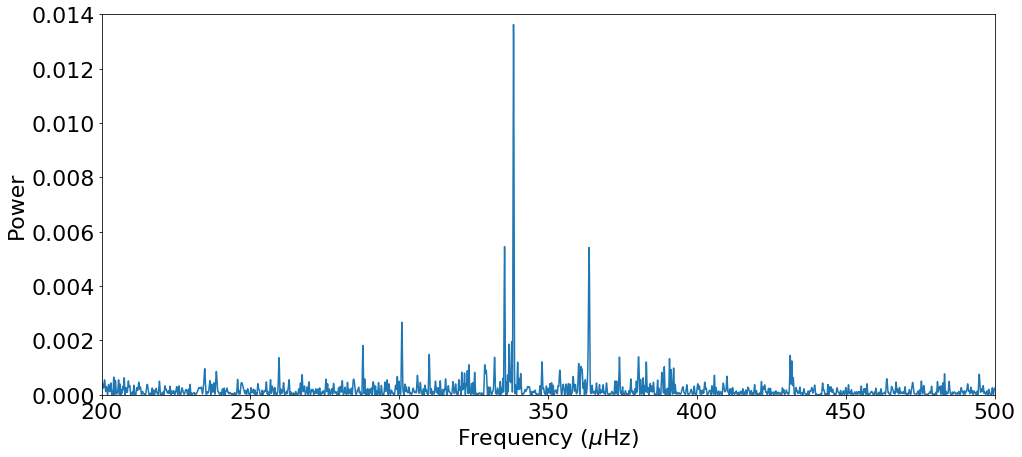

In [13]:
spower = savgol_filter(power,101,1)
# spower4 = savgol_filter(power4,101,1)

fig = plt.figure(figsize=(16,7))
plt.plot(frequency,power)

plt.xlim([200,500])
plt.ylim([0,0.014])

# plt.legend()
plt.xlabel('Frequency ($\mu$Hz)')
plt.ylabel('Power')

plt.savefig('nu-Ind-ps.png')

plt.show()

In [14]:
# threshs = np.arange(22)
# stds11 = []
# stds12 = []
# stds13 = []
# stds14 = []

In [15]:
# for thr in threshs:
#     weightmap11, corr_lc11 = tpf1.halo(order=2,mask=newmask,minflux=-100,thresh=thr,splits=(None,9221))
#     weightmap12, corr_lc12 = tpf1.halo(order=2,mask=newmask,minflux=-100,thresh=thr,splits=(9222,14687))
#     weightmap13, corr_lc13 = tpf1.halo(order=2,mask=newmask,minflux=-100,thresh=thr,splits=(14688,15340))
#     weightmap14, corr_lc14 = tpf1.halo(order=2,mask=newmask,minflux=-100,thresh=thr,splits=(15341,None))
    
#     fs11 = corr_lc11.flux[~numpy.isnan(corr_lc11.flux)]/np.nanmedian(corr_lc11.flux)
#     fs12 = corr_lc12.flux[~numpy.isnan(corr_lc12.flux)]/np.nanmedian(corr_lc12.flux)
#     fs13 = corr_lc13.flux[~numpy.isnan(corr_lc13.flux)]/np.nanmedian(corr_lc13.flux)
#     fs14 = corr_lc14.flux[~numpy.isnan(corr_lc14.flux)]/np.nanmedian(corr_lc14.flux)
    
#     sfs11 = savgol_filter(fs11,3001,1)
#     sfs12 = savgol_filter(fs12,2001,1)
#     sfs13 = savgol_filter(fs13,601,1)
#     sfs14 = savgol_filter(fs14,1001,1)
    
#     stds11=np.append(stds11,np.std(fs11/sfs11))
#     stds12=np.append(stds12,np.std(fs12/sfs12))
#     stds13=np.append(stds13,np.std(fs13/sfs13))
#     stds14=np.append(stds14,np.std(fs14/sfs14))

Taking cadences from beginning to 9221
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from 9222 to 14687
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from 14688 to 15340
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from 15341 to end
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from beginning to 9221
1 saturated pixels
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from 9222 to 14687
1 saturated pixels
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from 14688 to 15340
1 saturated pixels
Censored TPF
Subsampling by a facto

17
17
19
17


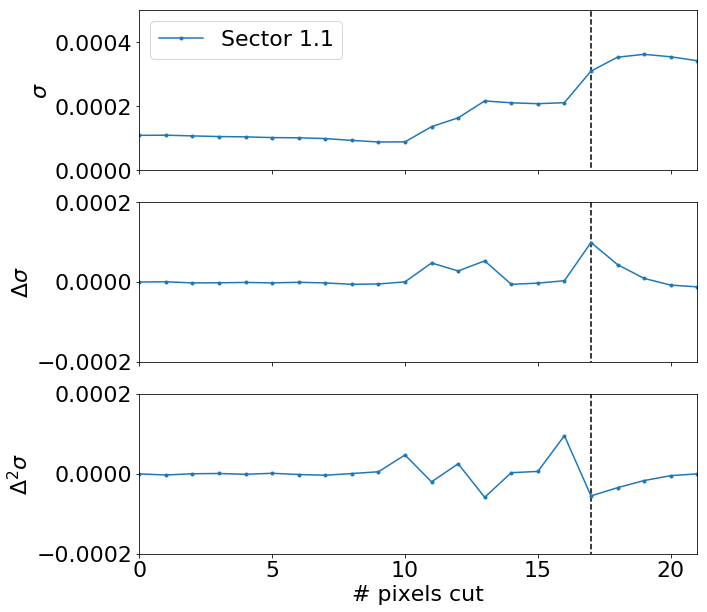

In [16]:
# # fig = plt.figure(figsize=(16,4))

# d1_11 = numpy.r_[0,stds11[1:]-stds11[:-1]]
# d1_12 = numpy.r_[0,stds12[1:]-stds12[:-1]]
# d1_13 = numpy.r_[0,stds13[1:]-stds13[:-1]]
# d1_14 = numpy.r_[0,stds14[1:]-stds14[:-1]]

# d2_11 = numpy.r_[0,stds11[2:]-2*stds11[1:-1]+stds11[:-2],0]
# d2_12 = numpy.r_[0,stds12[2:]-2*stds12[1:-1]+stds12[:-2],0]
# d2_13 = numpy.r_[0,stds13[2:]-2*stds13[1:-1]+stds13[:-2],0]
# d2_14 = numpy.r_[0,stds14[2:]-2*stds14[1:-1]+stds14[:-2],0]

# i1=[]
# cut=4
# while len(i1) == 0:
#     ind1 = (stds11 > cut*stds11[0]) & (d1_11 > 0) & numpy.r_[True, d2_11[1:] < d2_11[:-1]] & numpy.r_[d2_11[:-1] < d2_11[1:], True] & (d2_11 < 0)
#     i1=np.arange(len(ind1))[ind1]
#     cut -= 1

# if len(i1) > 3: i1=i1[i1.argsort(axis=None)][0:3]

# if threshs[i1[np.argmax(d1_11[i1])]] == threshs[i1[np.argmin(d2_11[i1])]]: 
#     pix1=threshs[i1[np.argmax(d1_11[i1])]]
#     print(pix1)
# else: 
#     p1 = i1[np.argmax(d1_11[i1])]
#     p2 = i1[np.argmin(d2_11[i1])]
#     if abs(d1_11[p1]-d1_11[p2]) > abs(d2_11[p1]-d2_11[p2]):
#         pix1=p1
#     else:
#         pix1=p2
        
# i2=[]
# cut=5
# while len(i2) == 0:
#     ind2 = (stds12 > cut*stds12[0]) & (d1_12 > 0) & numpy.r_[True, d2_12[1:] < d2_12[:-1]] & numpy.r_[d2_12[:-1] < d2_12[1:], True] & (d2_12 < 0)
#     i2=np.arange(len(ind2))[ind2]
#     cut -=1

# if len(i2) > 3: i2=i2[i2.argsort(axis=None)][0:3]

# if threshs[i2[np.argmax(d1_12[i2])]] == threshs[i2[np.argmin(d2_12[i2])]]: 
#     pix2=threshs[i2[np.argmax(d1_12[i2])]]
#     print(pix2)
# else: 
#     p1 = i2[np.argmax(d1_12[i2])]
#     p2 = i2[np.argmin(d2_12[i2])]
#     if abs(d1_12[p1]-d1_12[p2]) > abs(d2_12[p1]-d2_12[p2]):
#         pix2=p1
#     else:
#         pix2=p2
        
# i3=[]
# cut=5
# while len(i3) == 0:
#     ind3 = (stds13 > cut*stds13[0]) & (d1_13 > 0) & numpy.r_[True, d2_13[1:] < d2_13[:-1]] & numpy.r_[d2_13[:-1] < d2_13[1:], True] & (d2_13 < 0)
#     i3=np.arange(len(ind3))[ind3]
#     cut-=1

# if len(i3) > 3: i3=i3[i3.argsort(axis=None)][0:3]

# if threshs[i3[np.argmax(d1_13[i3])]] == threshs[i3[np.argmin(d2_13[i3])]]: 
#     pix3=threshs[i3[np.argmax(d1_13[i3])]]
#     print(pix3)
# else: 
#     p1 = i3[np.argmax(d1_13[i3])]
#     p2 = i3[np.argmin(d2_13[i3])]
#     if abs(d1_13[p1]-d1_13[p2]) > abs(d2_13[p1]-d2_13[p2]):
#         pix3=p1
#     else:
#         pix3=p2

# i4=[]
# cut=5
# while len(i4) == 0:
#     ind4 = (stds14 > cut*stds14[0]) & (d1_14 > 0) & numpy.r_[True, d2_14[1:] < d2_14[:-1]] & numpy.r_[d2_14[:-1] < d2_14[1:], True] & (d2_14 < 0)
#     i4=np.arange(len(ind4))[ind4]
#     cut-=1

# if len(i4) > 3: i4=i4[i4.argsort(axis=None)][0:3]

# if threshs[i4[np.argmax(d1_14[i4])]] == threshs[i4[np.argmin(d2_14[i4])]]: 
#     pix4=threshs[i4[np.argmax(d1_14[i4])]]
# else: 
#     p1 = i4[np.argmax(d1_14[i4])]
#     p2 = i4[np.argmin(d2_14[i4])]
#     if abs(d1_14[p1]-d1_14[p2]) > abs(d2_14[p1]-d2_14[p2]):
#         pix4=p1
#     else:
#         pix4=p2
# print(pix4)        
# #     print('Warning',threshs[i4[np.argmax(d1_14[i4])]],threshs[i4[np.argmin(d2_14[i4])]])
    
# fig, axs = plt.subplots(3, 1, sharex='col')

# axs[0].plot([pix1,pix1],[-1,1],'k--')
# axs[0].plot(threshs,stds11,'.-',label='Sector 1.1')
# # axs[0].plot([pix2,pix2],[-1,1],'k--')
# # axs[0].plot(threshs,stds12,'.-',label='Sector 1.2')
# # axs[0].plot([pix3,pix3],[-1,1],'k--')
# # axs[0].plot(threshs,stds13,'.-',label='Sector 1.3')
# # axs[0].plot([pix4,pix4],[-1,1],'k--')
# # axs[0].plot(threshs,stds14,'.-',label='Sector 1.4')
# # # axs[0].plot(threshs,stds21,'.-',label='Sector 2.1')
# # # axs[0].plot(threshs,stds22,'.-',label='Sector 2.2')
# axs[0].legend(loc=2)
# # .xlabel('# pixels cut')
# axs[0].set_ylabel('$\sigma$')
# axs[0].set_ylim([0,0.0005])
# axs[0].set_xlim([0,30])

# axs[1].plot([pix1,pix1],[-1,1],'k--')
# axs[1].plot(threshs,d1_11,'.-',label='Sector 1.1')
# # axs[1].plot([pix2,pix2],[-1,1],'k--')
# # axs[1].plot(threshs,d1_12,'.-',label='Sector 1.2')
# # axs[1].plot([pix3,pix3],[-1,1],'k--')
# # axs[1].plot(threshs,d1_13,'.-',label='Sector 1.3')
# # axs[1].plot([pix4,pix4],[-1,1],'k--')
# # axs[1].plot(threshs,d1_14,'.-',label='Sector 1.4')
# # # axs[1].plot(threshs[1:],stds21[1:]-stds21[:-1],'.-',label='Sector 2.1')
# # # axs[1].plot(threshs[1:],stds22[1:]-stds22[:-1],'.-',label='Sector 2.2')
# # axs[1].legend(loc=2)
# axs[1].set_ylabel('$\Delta\sigma$')
# axs[1].set_ylim([-0.0002,0.0002])
# axs[1].set_xlim([0,30])

# axs[2].plot([pix1,pix1],[-1,1],'k--')
# axs[2].plot(threshs,d2_11,'.-',label='Sector 1.1')
# # axs[2].plot([pix2,pix2],[-1,1],'k--')
# # axs[2].plot(threshs,d2_12,'.-',label='Sector 1.2')
# # axs[2].plot([pix3,pix3],[-1,1],'k--')
# # axs[2].plot(threshs,d2_13,'.-',label='Sector 1.3')
# # axs[2].plot([pix4,pix4],[-1,1],'k--')
# # axs[2].plot(threshs,d2_14,'.-',label='Sector 1.4')
# # # axs[2].plot(threshs,stds21[2:]-2*stds21[1:-1]+stds21[:-2],'.-',label='Sector 2.1')

# # # axs[2].plot(threshs,stds22[2:]-2*stds22[1:-1]+stds22[:-2],'.-',label='Sector 2.2')
# # axs[2].plot([0,1000],[0.0001,0.0001])
# # axs[2].plot([0,1000],[0.0003,0.0003])
# # axs[2].plot(threshs,stds2/np.sqrt(threshs),'.-',label='Sector 2')
# # axs[2].legend(loc=2)
# axs[2].set_xlabel('# pixels cut')
# axs[2].set_ylabel('$\Delta^2\sigma$')
# axs[2].set_ylim([-0.0002,0.0002])
# axs[2].set_xlim([0,21])
# plt.show()